***
<font size="6"><center><b> B-CNN: CIFAR-100 Model B </b></center></font>
***

# Imports Necessary libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import get_file
from tensorflow.keras import backend as K
# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
    #import other libraries
import math
import random

sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models
from treelib import Tree

DONE loading MixUp Data generator
DONE loading MixUp Data generator


## LOG File Directory

In [3]:
base_path = "./logs/B_CNN"
if not os.path.exists(base_path):
    os.makedirs(base_path)
    print("FOLDER CREATED = ", base_path)
else:
    print("Warning: Folder already exist.")

FOLDER CREATED =  ./logs/B_CNN


### For GPU growth (not required if GPU does not give any error)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Done: GPU "+str(gpu))
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [5]:
def scheduler(epoch):
  learning_rate_init = 0.001
  if epoch > 55:
    learning_rate_init = 0.0002
  if epoch > 70:
    learning_rate_init = 0.00005
  return learning_rate_init

In [6]:
class LossWeightsModifier(keras.callbacks.Callback):
  def __init__(self, alpha, beta, gamma):
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
    # customize your behavior
  def on_epoch_end(self, epoch, logs={}):
    if epoch == 13:
      K.set_value(self.alpha, 0.1)
      K.set_value(self.beta, 0.8)
      K.set_value(self.gamma, 0.1)
    if epoch == 23:
      K.set_value(self.alpha, 0.1)
      K.set_value(self.beta, 0.2)
      K.set_value(self.gamma, 0.7)
    if epoch == 33:
      K.set_value(self.alpha, 0)
      K.set_value(self.beta, 0)
      K.set_value(self.gamma, 1)

In [7]:
#-------- dimensions ---------
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)
#-----------------------------

train_size = 50000

#--- coarse 1 classes ---
num_c_1 = 8
#--- coarse 2 classes ---
num_c_2 = 20
#--- fine classes ---
num_classes  = 100

batch_size   = 128
epochs       = 80

#--- file paths ---
log_filepath = base_path+'/tb_logs/'
weights_store_filepath = base_path+'/model_weights/'

In [8]:
#-------------------- data loading ----------------------
# (x_train, y_c2_train), (x_test, y_c2_test) = cifar100.load_data(label_mode='coarse')
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# y_c2_train = keras.utils.to_categorical(y_c2_train, num_c_2)
# y_c2_test = keras.utils.to_categorical(y_c2_test, num_c_2)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#---------------- data preprocessiong -------------------
x_train = (x_train-np.mean(x_train)) / np.std(x_train)
x_test = (x_test-np.mean(x_test)) / np.std(x_test)

#---------------------- make coarse 2 labels --------------------------
parent_f = {
0:4,1:1,2:14,3:8,4:0,5:6,6:7,7:7,8:18,9:3,
10:3,11:14,12:9,13:18,14:7,15:11,16:3,17:9,18:7,19:11,
20:6,21:11,22:5,23:10,24:7,25:6,26:13,27:15,28:3,29:15,
30:0,31:11,32:1,33:10,34:12,35:14,36:16,37:9,38:11,39:5,
40:5,41:19,42:8,43:8,44:15,45:13,46:14,47:17,48:18,49:10,
50:16,51:4,52:17,53:4,54:2,55:0,56:17,57:4,58:18,59:17,
60:10,61:3,62:2,63:12,64:12,65:16,66:12,67:1,68:9,69:19,
70:2,71:10,72:0,73:1,74:16,75:12,76:9,77:13,78:15,79:13,
80:16,81:19,82:2,83:4,84:6,85:19,86:5,87:5,88:8,89:19,
90:18,91:1,92:2,93:15,94:6,95:0,96:17,97:8,98:14,99:13
}
y_c2_train = np.zeros((y_train.shape[0], num_c_2)).astype("float32")
y_c2_test = np.zeros((y_test.shape[0], num_c_2)).astype("float32")
for i in range(y_c2_train.shape[0]):
  y_c2_train[i][parent_f[np.argmax(y_train[i])]] = 1.0
for i in range(y_c2_test.shape[0]):
  y_c2_test[i][parent_f[np.argmax(y_test[i])]] = 1.0

#---------------------- make coarse 1 labels --------------------------
parent_c2 = {
  0:0, 1:0, 2:1, 3:2, 
  4:1, 5:2, 6:2, 7:3, 
  8:4, 9:5, 10:5, 11:4, 
  12:4, 13:3, 14:6, 15:4, 
  16:4, 17:1, 18:7, 19:7
}
y_c1_train = np.zeros((y_c2_train.shape[0], num_c_1)).astype("float32")
y_c1_test = np.zeros((y_c2_test.shape[0], num_c_1)).astype("float32")
for i in range(y_c1_train.shape[0]):
  y_c1_train[i][parent_c2[np.argmax(y_c2_train[i])]] = 1.0
for i in range(y_c1_test.shape[0]):
  y_c1_test[i][parent_c2[np.argmax(y_c2_test[i])]] = 1.0

In [9]:
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

print("y_c2_train shape: ", y_c2_train.shape)
print("y_c2_test shape: ", y_c2_test.shape)
print("y_c1_train shape: ", y_c1_train.shape)
print("y_c1_test shape: ", y_c1_test.shape)

x_train shape:  (50000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)
y_train shape:  (50000, 100)
y_test shape:  (10000, 100)
y_c2_train shape:  (50000, 20)
y_c2_test shape:  (10000, 20)
y_c1_train shape:  (50000, 8)
y_c1_test shape:  (10000, 8)


In [10]:
#----------------------- model definition ---------------------------
alpha = K.variable(value=0.98, dtype="float32", name="alpha") # A1 in paper
beta = K.variable(value=0.01, dtype="float32", name="beta") # A2 in paper
gamma = K.variable(value=0.01, dtype="float32", name="gamma") # A3 in paper

In [11]:
img_input = Input(shape=input_shape, name='input')

#--- block 1 ---
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

#--- block 2 ---
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

#--- coarse 1 branch ---
c_1_bch = Flatten(name='c1_flatten')(x)
c_1_bch = Dense(256, activation='relu', name='c1_fc_cifar10_1')(c_1_bch)
c_1_bch = BatchNormalization()(c_1_bch)
c_1_bch = Dropout(0.5)(c_1_bch)
c_1_bch = Dense(256, activation='relu', name='c1_fc2')(c_1_bch)
c_1_bch = BatchNormalization()(c_1_bch)
c_1_bch = Dropout(0.5)(c_1_bch)
c_1_pred = Dense(num_c_1, activation='softmax', name='c1_predictions_cifar10')(c_1_bch)

#--- block 3 ---
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#--- coarse 2 branch ---
c_2_bch = Flatten(name='c2_flatten')(x)
c_2_bch = Dense(512, activation='relu', name='c2_fc_cifar10_1')(c_2_bch)
c_2_bch = BatchNormalization()(c_2_bch)
c_2_bch = Dropout(0.5)(c_2_bch)
c_2_bch = Dense(512, activation='relu', name='c2_fc2')(c_2_bch)
c_2_bch = BatchNormalization()(c_2_bch)
c_2_bch = Dropout(0.5)(c_2_bch)
c_2_pred = Dense(num_c_2, activation='softmax', name='c2_predictions_cifar10')(c_2_bch)

#--- block 4 ---
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#--- fine block ---
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='fc_cifar10_1')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
fine_pred = Dense(num_classes, activation='softmax', name='predictions_cifar10')(x)

In [12]:
model = Model(img_input, [c_1_pred, c_2_pred, fine_pred], name='medium_dynamic')

In [13]:
model.summary()

Model: "medium_dynamic"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalizatio

                                                                                                  
 fc2 (Dense)                    (None, 1024)         1049600     ['dropout_4[0][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 256)         1024        ['c1_fc2[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 512)         2048        ['c2_fc2[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_13 (BatchN  (None, 1024)        4096        ['fc2[0][0]']                    
 ormalizat

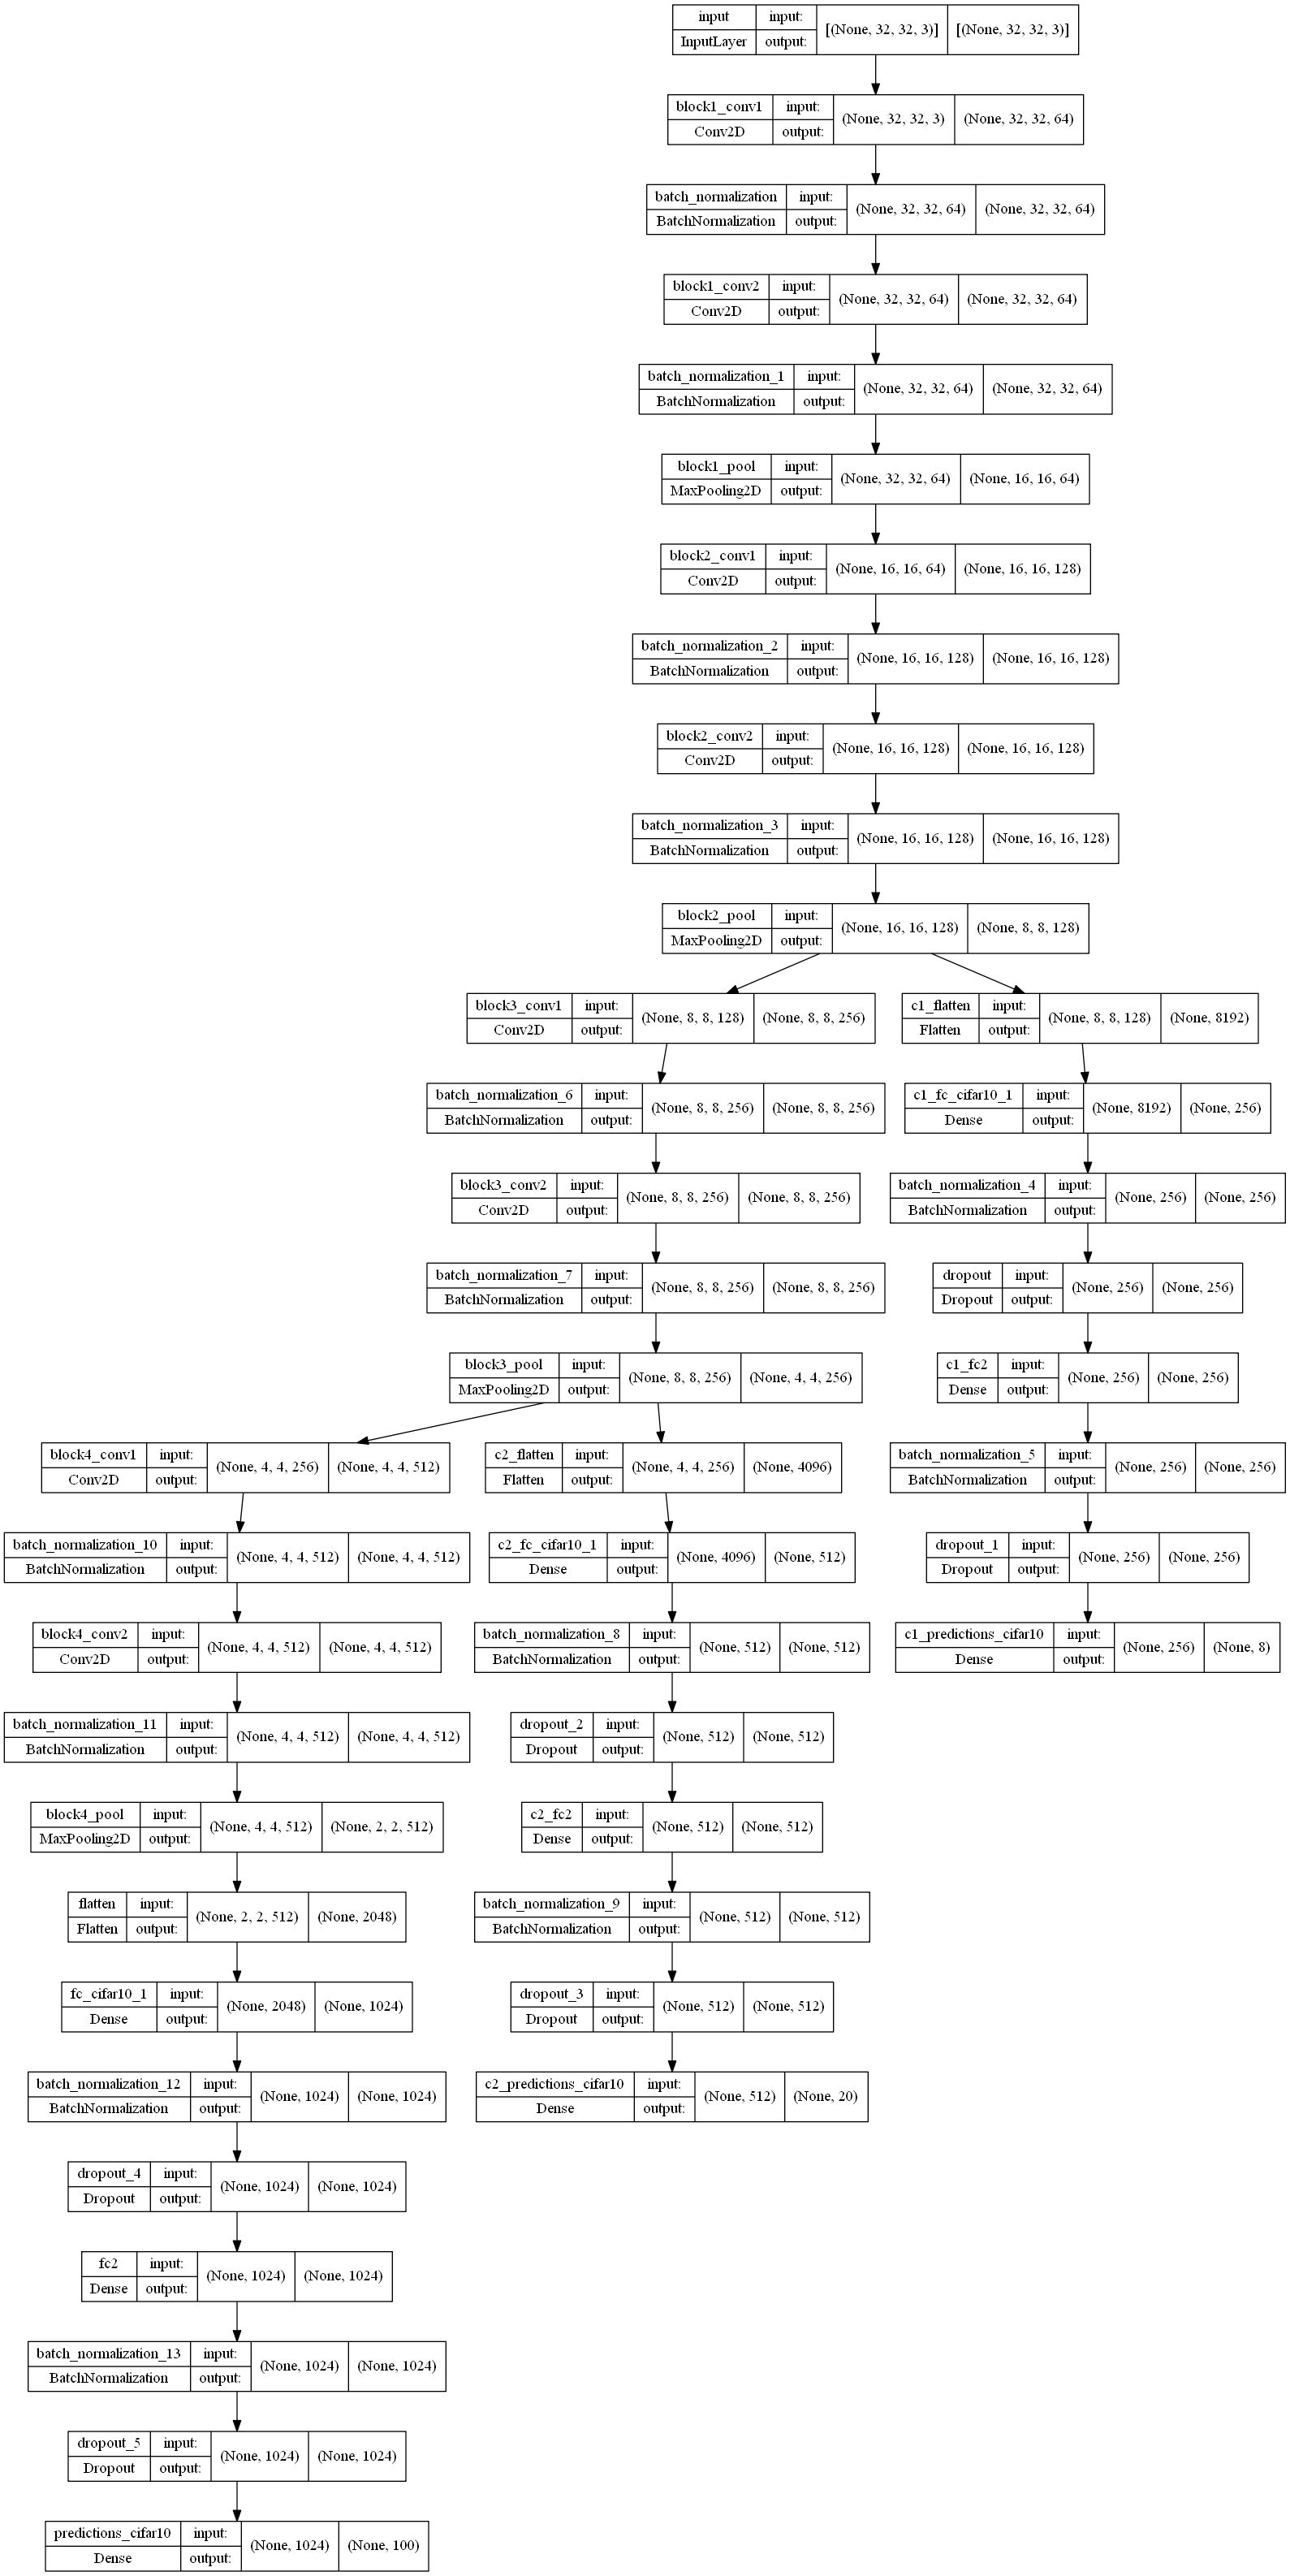

In [14]:
keras.utils.plot_model(model, base_path+"/b-cnn.png",show_shapes=True)

In [15]:
#----------------------- compile and fit ---------------------------
sgd = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              loss_weights=[alpha, beta, gamma],
              # optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

log = keras.callbacks.CSVLogger(base_path+'/log.csv', append=True)
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
change_lw = LossWeightsModifier(alpha, beta, gamma)
cbks = [change_lr, tb_cb, change_lw, log]

C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [16]:
try:
    model.load_weights(base_path+'/trained_model.h5')
except:
    model.fit(x_train, [y_c1_train, y_c2_train, y_train],
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=cbks,
              validation_data=(x_test, [y_c1_test, y_c2_test, y_test]))
    model.save_weights(base_path+'/trained_model.h5')

In [17]:
score = model.evaluate(x_test, [y_c1_test, y_c2_test, y_test], verbose=1)
print('score is: ', score)

score is:  [0.8402805924415588, 0.824715793132782, 1.1911524534225464, 2.0147578716278076, 0.7107999920845032, 0.6198999881744385, 0.5637999773025513]


In [18]:
for n in range(len(score)):
    print(str(n+1)+'.',model.metrics_names[n], '==>', score[n])

1. loss ==> 0.8402805924415588
2. c1_predictions_cifar10_loss ==> 0.824715793132782
3. c2_predictions_cifar10_loss ==> 1.1911524534225464
4. predictions_cifar10_loss ==> 2.0147578716278076
5. c1_predictions_cifar10_accuracy ==> 0.7107999920845032
6. c2_predictions_cifar10_accuracy ==> 0.6198999881744385
7. predictions_cifar10_accuracy ==> 0.5637999773025513


# END

# Precision & Recall

In [19]:
predictions = model.predict(x_test, verbose=1)
for n in range(len(predictions)):
    print(str(n+1)+'.',predictions[n].shape, '==>', 'predictions[{A}]'.format(A=n))

313/313 [==============================] - 4s 10ms/step
1. (10000, 8) ==> predictions[0]
2. (10000, 20) ==> predictions[1]
3. (10000, 100) ==> predictions[2]


# sklearn: Performance parameters

{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
[0, 1, 2, 3, 4, 5, 6, 7]
['0', '1', '2', '3', '4', '5', '6', '7']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68

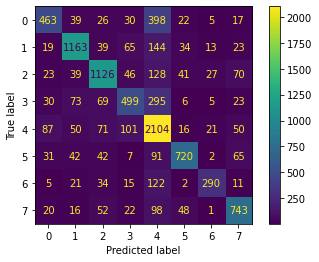

              precision    recall  f1-score   support

           0    0.68289   0.46300   0.55185      1000
           1    0.80596   0.77533   0.79035      1500
           2    0.77176   0.75067   0.76107      1500
           3    0.63567   0.49900   0.55910      1000
           4    0.62249   0.84160   0.71565      2500
           5    0.80990   0.72000   0.76231      1000
           6    0.79670   0.58000   0.67130       500
           7    0.74152   0.74300   0.74226      1000

    accuracy                        0.71080     10000
   macro avg    0.73336   0.67158   0.69423     10000
weighted avg    0.71911   0.71080   0.70674     10000


  • MEDIUM LEVEL 


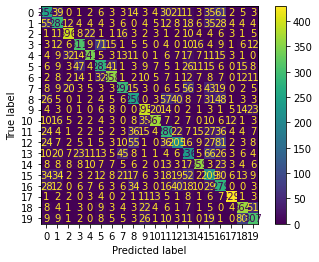

              precision    recall  f1-score   support

           0    0.48940   0.50800   0.49853       500
           1    0.56238   0.56800   0.56517       500
           2    0.79200   0.79200   0.79200       500
           3    0.67904   0.62200   0.64927       500
           4    0.79673   0.68200   0.73491       500
           5    0.57992   0.56600   0.57287       500
           6    0.74739   0.71600   0.73136       500
           7    0.66364   0.58400   0.62128       500
           8    0.52743   0.50000   0.51335       500
           9    0.71429   0.79000   0.75024       500
          10    0.83220   0.73400   0.78002       500
          11    0.52142   0.56000   0.54002       500
          12    0.52972   0.41000   0.46223       500
          13    0.42987   0.47200   0.44995       500
          14    0.76874   0.71800   0.74250       500
          15    0.35424   0.41800   0.38349       500
          16    0.40493   0.55800   0.46930       500
          17    0.89004   0

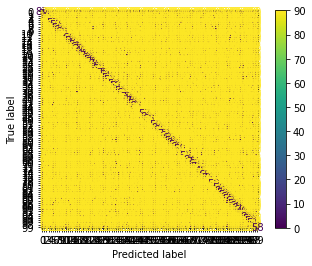

              precision    recall  f1-score   support

           0    0.82178   0.83000   0.82587       100
           1    0.67273   0.74000   0.70476       100
           2    0.46939   0.46000   0.46465       100
           3    0.36585   0.30000   0.32967       100
           4    0.30579   0.37000   0.33484       100
           5    0.62637   0.57000   0.59686       100
           6    0.53774   0.57000   0.55340       100
           7    0.60440   0.55000   0.57592       100
           8    0.81176   0.69000   0.74595       100
           9    0.68317   0.69000   0.68657       100
          10    0.49438   0.44000   0.46561       100
          11    0.50000   0.35000   0.41176       100
          12    0.60000   0.66000   0.62857       100
          13    0.63529   0.54000   0.58378       100
          14    0.57500   0.46000   0.51111       100
          15    0.49541   0.54000   0.51675       100
          16    0.63918   0.62000   0.62944       100
          17    0.76596   0

In [20]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

cloarse_classes_number = num_c_1 #from model architecture
medium_classes_number = num_c_2
fine_classes_number = num_classes

y_true_coarse = np.argmax(y_c1_test, axis=1)
y_pred_coarse = np.argmax(predictions[0], axis=1)

y_true_medium = np.argmax(y_c2_test, axis=1)
y_pred_medium = np.argmax(predictions[1], axis=1)

y_true_fine = np.argmax(y_test, axis=1)
y_pred_fine = np.argmax(predictions[2], axis=1)

output = set()
for x in y_true_coarse:
    output.add(x)
print(output)

for x in y_true_medium:
    output.add(x)
print(output)

for x in y_true_fine:
    output.add(x)
print(output)

coarse_labels = list(range(0, cloarse_classes_number))
coarse_target_names = [str(x) for x in list(range(0, cloarse_classes_number))]
medium_labels = list(range(0, medium_classes_number))
medium_target_names = [str(x) for x in list(range(0, medium_classes_number))]
fine_labels = list(range(0, fine_classes_number))
fine_target_names = [str(x) for x in list(range(0, fine_classes_number))]
print(coarse_labels)
print(coarse_target_names)
print(medium_labels)
print(medium_target_names)
print(fine_labels)
print(fine_target_names)

def confusion_matrixDisplay(y_true, y_pred, target_names):
    labels = target_names
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot()
    plt.show()
    #plt.savefig("Confusion_Matrix.png")

print('\n\033[91m','\033[1m',"\u2022",'multilabel-Confusion_Matrix','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_coarse, y_pred_coarse))
print('\n\033[91m','\033[1m',"\u2022",'MEDIUM LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_medium, y_pred_medium))
print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_fine, y_pred_fine))

print('\n\033[91m','\033[1m',"\u2022",'Confusion_Matrix','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
print(confusion_matrix(y_true_coarse, y_pred_coarse))
print('\n\033[91m','\033[1m',"\u2022",'MEDIUM LEVEL','\033[0m')
print(confusion_matrix(y_true_medium, y_pred_medium))
print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
print(confusion_matrix(y_true_fine, y_pred_fine))

print('\n\033[91m','\033[1m',"\u2022",'Classification Report','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
confusion_matrixDisplay(y_true_coarse, y_pred_coarse, coarse_target_names)
print(classification_report(y_true_coarse, y_pred_coarse, target_names=coarse_target_names, digits=5))
print('\n\033[91m','\033[1m',"\u2022",'MEDIUM LEVEL','\033[0m')
confusion_matrixDisplay(y_true_medium, y_pred_medium, medium_target_names)
print(classification_report(y_true_medium, y_pred_medium, target_names=medium_target_names, digits=5))
print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
confusion_matrixDisplay(y_true_fine, y_pred_fine, fine_target_names)
print(classification_report(y_true_fine, y_pred_fine, target_names=fine_target_names, digits=5))

# hierarchical_PrecisionRecallF1

In [21]:
tree = Tree()
tree.create_node("Root", "root")  # root node
for i in range(8):
    tree.create_node('L0_'+ str(i), 'L0_'+ str(i), parent="root")

def mediumlevel(previous_lvl, new_lvl):
    
    tree.create_node('L1_'+str(new_lvl), 'L1_'+str(new_lvl), 'L0_'+str(previous_lvl))

def finelevel(previous_lvl, new_lvl):
    
    tree.create_node('L2_'+str(new_lvl), 'L2_'+str(new_lvl), 'L1_'+str(previous_lvl))

for i in range(len(parent_c2)):
    mediumlevel(parent_c2[i], i)

for i in range(len(parent_f)):
    finelevel(parent_f[i], i)
tree.show()

Root
├── L0_0
│   ├── L1_0
│   │   ├── L2_30
│   │   ├── L2_4
│   │   ├── L2_55
│   │   ├── L2_72
│   │   └── L2_95
│   └── L1_1
│       ├── L2_1
│       ├── L2_32
│       ├── L2_67
│       ├── L2_73
│       └── L2_91
├── L0_1
│   ├── L1_17
│   │   ├── L2_47
│   │   ├── L2_52
│   │   ├── L2_56
│   │   ├── L2_59
│   │   └── L2_96
│   ├── L1_2
│   │   ├── L2_54
│   │   ├── L2_62
│   │   ├── L2_70
│   │   ├── L2_82
│   │   └── L2_92
│   └── L1_4
│       ├── L2_0
│       ├── L2_51
│       ├── L2_53
│       ├── L2_57
│       └── L2_83
├── L0_2
│   ├── L1_3
│   │   ├── L2_10
│   │   ├── L2_16
│   │   ├── L2_28
│   │   ├── L2_61
│   │   └── L2_9
│   ├── L1_5
│   │   ├── L2_22
│   │   ├── L2_39
│   │   ├── L2_40
│   │   ├── L2_86
│   │   └── L2_87
│   └── L1_6
│       ├── L2_20
│       ├── L2_25
│       ├── L2_5
│       ├── L2_84
│       └── L2_94
├── L0_3
│   ├── L1_13
│   │   ├── L2_26
│   │   ├── L2_45
│   │   ├── L2_77
│   │   ├── L2_79
│   │   └── L2_99
│   └── L1_7
│       ├── L2_14
│   

In [22]:
true_label = [y_true_coarse.tolist(), y_true_medium.tolist(), y_true_fine.tolist()]
pred_label = [predictions[0],predictions[1],predictions[2]]

In [23]:
h_measurements = metrics.get_hierarchical_metrics(true_label, pred_label, tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2])
print('\nH Accuracy=',
     metrics.get_h_accuracy(true_label, pred_label),
     '\nThis method computes the harmonic mean of accuracies of all level in the taxonomy.',)

print('\nM Accuracy=',
     metrics.get_m_accuracy(true_label, pred_label),
     '\nThis method computes the harmonic mean of accuracies of all level in the taxonomy.',
      )

print('\nExact_Match=',
     metrics.get_exact_match(true_label, pred_label),
     '\nThis method compute the exact match score. Exact match is defined as the #of examples for which the predictions for all level in the taxonomy is correct by the total #of examples.',
      )

print('\nConsistency=',
     metrics.get_consistency(pred_label, tree),
     '\nThis methods estimates the consistency.',
      )


Hierarchical Precision = 0.64413 
Hierarchical Recall = 0.7342333333333333 
Hierarchical F1-Score = 0.6793067460317459

H Accuracy= 0.6258204079798294 
This method computes the harmonic mean of accuracies of all level in the taxonomy.

M Accuracy= 0.6315 
This method computes the harmonic mean of accuracies of all level in the taxonomy.

Exact_Match= 0.389 
This method compute the exact match score. Exact match is defined as the #of examples for which the predictions for all level in the taxonomy is correct by the total #of examples.

Consistency= 0.5687 
This methods estimates the consistency.
